In [2]:
import numpy as np
import matplotlib.pyplot as plt
import simulate
import convergence

/home/okumura/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/okumura/.local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


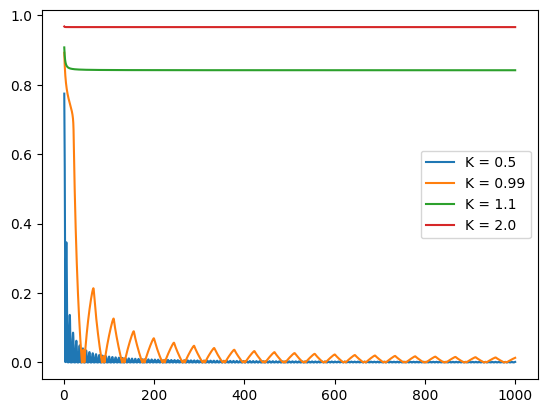

In [4]:
model = simulate.OscilatorNetwork()

k = 0.90
w = 1

def f(k):
    K = np.array([[0, k], [k, 0]])
    w0 = [-w, w]
    ts, ss = model.solve_rk4(K, w0, T=1000)

    ts = ts[100:]
    ss = ss[100:]

    cos_ss = np.mean(np.cos(ss), axis=1)
    sin_ss = np.mean(np.sin(ss), axis=1)

    R_ts = [np.sqrt(np.mean(cos_ss[:i])**2 + np.mean(sin_ss[:i])**2) for i in range(cos_ss.shape[0])]
    plt.plot(ts, R_ts, label=f"K = {k}")

f(0.50)
f(0.99)
f(1.10)
f(2.0)
plt.legend()

(-0.01, 1.01)

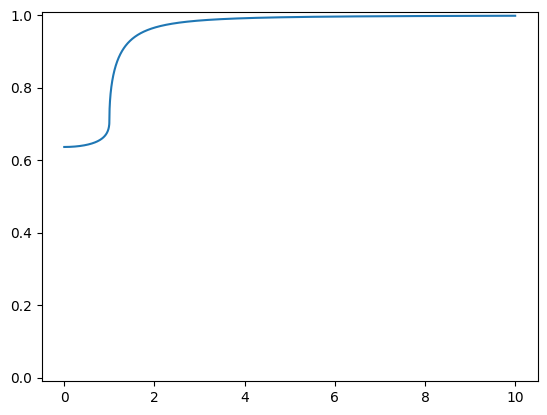

In [10]:
def map2R(ss):
    if ss.ndim == 1:
        return np.sqrt(np.mean(np.cos(ss))**2 + np.mean(np.sin(ss))**2)
        
    if ss.ndim == 2:
        return np.sqrt(np.mean(np.cos(ss), axis=1)**2 + np.mean(np.sin(ss), axis=1)**2)
        

def theoretical_R(K, w):
    if K >= w:
        return np.cos(0.5 * np.arcsin(w / K))
    else:
        Z = np.pi / np.sqrt(w**2 - K**2)

        x = np.linspace(-np.pi / 2, np.pi / 2, 10000)
        f_x = np.cos(x) / (w - K * np.sin(2 * x))
        return np.sum(f_x * (x[1] - x[0])) / Z


w = 1
K_list = np.linspace(0, 10., 10000)
R_list = np.array([theoretical_R(K, w) for K in K_list])

plt.plot(K_list, R_list)
plt.ylim((-0.01, 1.01))

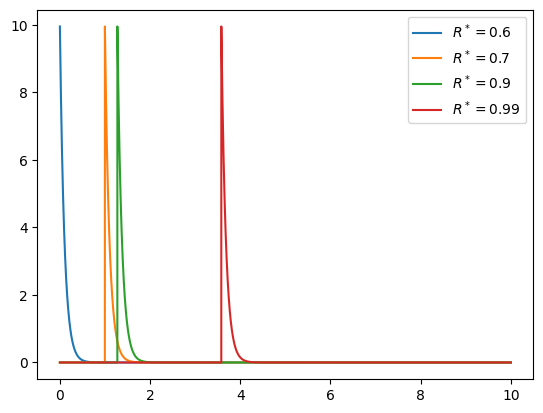

In [5]:
beta = 10.0

for R_limit in [0.6, 0.7, 0.9, 0.99]:
    limited_f = np.where(R_list > R_limit, np.exp(- beta * K_list), 0.)
    limited_p = limited_f / (np.sum(limited_f) * (K_list[1] - K_list[0]))

    plt.plot(K_list, np.where(limited_p > 0, limited_p, 0.), label=f"$R^*={R_limit}$")
plt.legend()

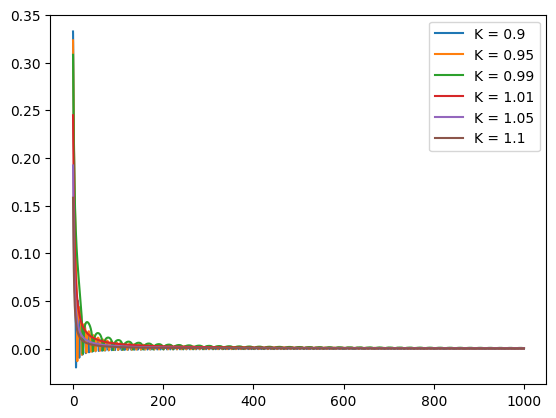

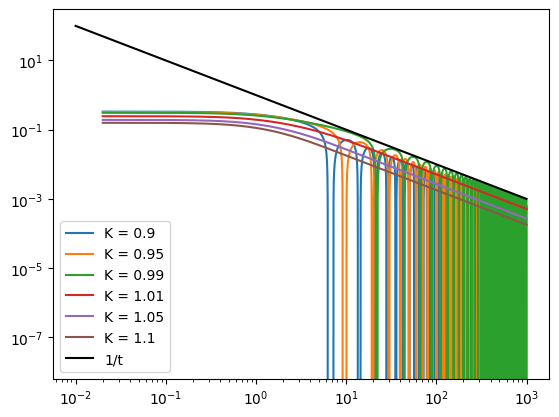

In [6]:


def acc_test_rk4(K, w, dt=0.01):
    model = simulate.OscilatorNetwork()
    sampling_times, ss = model.solve_rk4(np.array([[0, K], [K, 0]]), w0=np.array([-w, w]), T=1000, dt=dt)
    R_actuals = map2R(ss)
    
    R_theory = theoretical_R(K, w)
    dR = [np.mean(R_actuals[:n]) - R_theory for n in range(1, ss.shape[0])]
    
    return sampling_times[1:], dR
    

result = {}
w = 1.0
for K in [0.9, 0.95, 0.99, 1.01, 1.05, 1.1]:
    result[K] = acc_test_rk4(K, w)

for K in result:
    times, dR = result[K]
    plt.plot(times, dR, label=f"K = {K}")
plt.legend()
plt.show()

for K in result:
    times, dR = result[K]
    plt.plot(times, dR, label=f"K = {K}")
x = np.linspace(0.1, 1000, 10000)
plt.plot(x, 1 / x, c="black", label="1/t")
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.show()

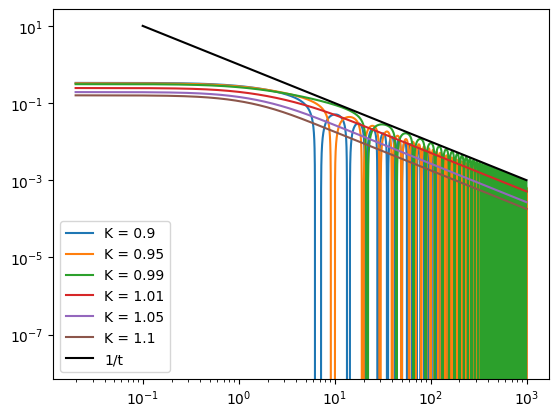

In [7]:
for K in result:
    times, dR = result[K]
    plt.plot(times, dR, label=f"K = {K}")
x = np.linspace(0.1, 1000, 10000)
plt.plot(x, 1 / x, c="black", label="1/t")
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.show()

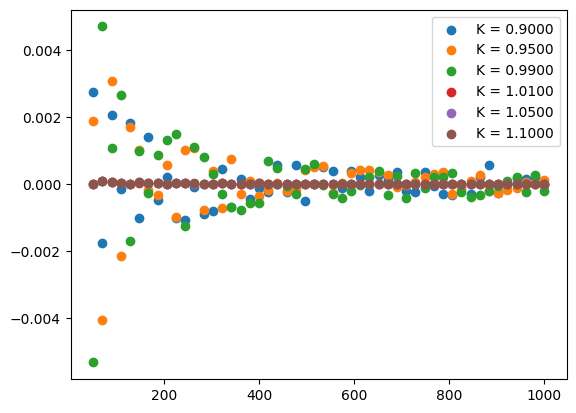

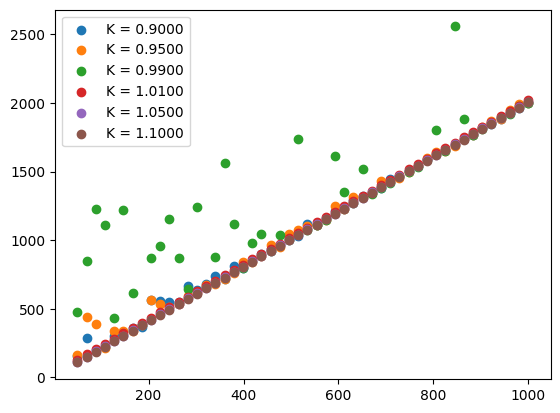

In [11]:
def converged_test(K, w=1., label=None, dt=0.01, conv_eps=1e-6, window_T=100, burnin_T = 0):
    model = simulate.OscilatorNetwork()
    conv = convergence.OnlineMean(window_T / dt, burnin_T / dt)
    conv_eps = 1e-6
    for e, t, s in model.solve_rk4_iter(np.array([[0, K], [K, 0]]), w0=np.array([-w, w]), dt=dt):
        R_actual = map2R(s)
        if conv.append(R_actual) < conv_eps:
            R_actual = conv.value()
            t_actual = t
            break

        if t > 5000:
            return np.nan, t

    R_theory = theoretical_R(K, w)
    dR = R_theory - R_actual
    return dR, t_actual

result = dict()
window_T_list = np.linspace(50, 1000, 50)
for K in [0.9, 0.95, 0.99, 1.01, 1.05, 1.1]:
    dR_T = [converged_test(K=K, window_T=window) for window in window_T_list]
    dR_list = [dR for dR, t in dR_T]
    T_list = [t for dR, t in dR_T]
    
    result[K] = (dR_list, T_list)

for K in result:
    plt.scatter(window_T_list, result[K][0], label=f"K = {K:.4f}")
plt.legend()
plt.show()

for K in result:
    plt.scatter(window_T_list, result[K][1], label=f"K = {K:.4f}")
plt.legend()
plt.show()

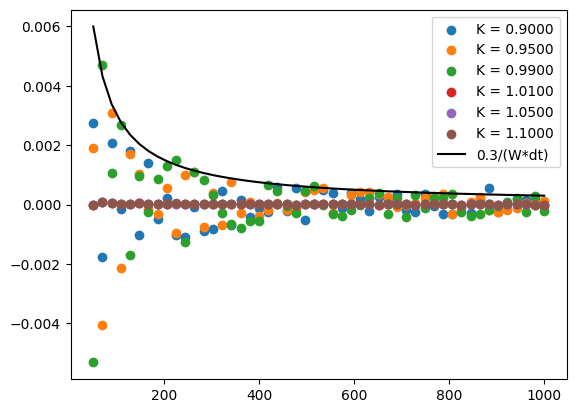

In [24]:
for K in result:
    plt.scatter(window_T_list, result[K][0], label=f"K = {K:.4f}")
plt.plot(window_T_list, 0.3/ window_T_list, label="0.3/(W*dt)", c="black")
plt.legend()
plt.show()

In [26]:
_K_list = np.linspace(0, 2, 100)
_res = [converged_test(K=K, window_T=1.) for K in _K_list]
plt.plot(_K_list, _res)

In [25]:
plt.plot(_K_list, [dR for dR, t in _res])

NameError: name '_K_list' is not defined

In [ ]:
def acc_test_rk4_with_burnin(K, w, label=None, burn_in=100):
    model = simulate.OscilatorNetwork()
    samping_times, ss = model.solve_rk4(np.array([[0, K], [K, 0]]), w0=np.array([-w, w]), T=1000)
    
    ss = ss[samping_times > burn_in]
    samping_times = samping_times[samping_times > burn_in]
    
    R_actuals = map2R(ss)
    
    R_theory = theoretical_R(K, w)
    dR = [np.mean(R_actuals[:n]) - R_theory for n in range(1, ss.shape[0])]
    
    plt.plot(samping_times[1:], np.abs(dR), label=f"K = {K:.4f}, w = {w:.4f}" if label is None else label)
    

w = 1.0
for K in [0.9, 0.95, 0.99, 1.01, 1.05, 1.1]:
    acc_test_rk4_with_burnin(K, w, label=f"K = {K}")

plt.yscale("log")
plt.legend()

In [ ]:
def acc_test_rk4_trapezoid(K, w, label=None):
    model = simulate.OscilatorNetwork()
    samping_times, ss = model.solve_rk4(np.array([[0, K], [K, 0]]), w0=np.array([-w, w]), T=1000)
    R_actuals = map2R(ss)
    
    R_theory = theoretical_R(K, w)
    def trapezoid(t, x):
        n = x.shape[0]
        return ((x[-1] + x[0]) / 2 + np.sum(x[1:-1])) / n
    dR = [trapezoid(samping_times, R_actuals[:n]) - R_theory for n in range(1, ss.shape[0])]
    
    plt.plot(samping_times[1:], np.abs(dR), label=f"K = {K:.4f}, w = {w:.4f}" if label is None else label)
    

w = 1.0
for K in [0.9, 0.95, 0.99, 1.01, 1.05, 1.1]:
    acc_test_rk4_trapezoid(K, w, label=f"K = {K}")

plt.yscale("log")
plt.legend()

In [ ]:
def acc_test_rk4_simpson(K, w, label=None):
    model = simulate.OscilatorNetwork()
    samping_times, ss = model.solve_rk4(np.array([[0, K], [K, 0]]), w0=np.array([-w, w]), T=1000)
    R_actuals = map2R(ss)
    
    R_theory = theoretical_R(K, w)
    def simpson(t, x):
        n = x.shape[0]
        return ((x[0] + x[-1]) + (x[1] + x[-2]) * 5 + np.sum(x[2:-3]) * 6) / (6*n)
    dR = [simpson(samping_times, R_actuals[:n]) - R_theory for n in range(5, ss.shape[0])]
    
    plt.plot(samping_times[5:], np.abs(dR), label=f"K = {K:.4f}, w = {w:.4f}" if label is None else label)
    

w = 1.0
for K in [0.9, 0.95, 0.99, 1.01, 1.05, 1.1]:
    acc_test_rk4_simpson(K, w, label=f"K = {K}")

plt.yscale("log")
plt.legend()

In [ ]:
w = 1.0
K = 0.99
acc_test_rk4(K, w, label=f"square")
acc_test_rk4_trapezoid(K, w, label=f"trapezoid")
acc_test_rk4_simpson(K, w, label=f"simpson")
plt.yscale("log")
plt.legend()

In [ ]:
w = 1.0
K = 0.99
for dt in [0.1, 0.01, 0.001]:
    acc_test_rk4(K, w, label=f"dt = {dt:.4f}", dt=dt)
plt.yscale("log")
plt.legend()